<a href="https://colab.research.google.com/github/edmilsonsgjk/fraude_detection/blob/master/iee_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
#from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt
#files.upload()

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "xxxx" # username from the json file 
os.environ['KAGGLE_KEY'] = "xxxx" # key from the json file
!kaggle competitions download -c ieee-fraud-detection # api copied from kaggle

 78% 41.0M/52.5M [00:00<00:00, 35.8MB/s]
100% 52.5M/52.5M [00:00<00:00, 67.5MB/s]
  0% 0.00/3.02M [00:00<?, ?B/s]
100% 3.02M/3.02M [00:00<00:00, 190MB/s]
 87% 41.0M/47.3M [00:00<00:00, 36.8MB/s]
100% 47.3M/47.3M [00:00<00:00, 57.3MB/s]
  0% 0.00/2.97M [00:00<?, ?B/s]
100% 2.97M/2.97M [00:00<00:00, 201MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 156MB/s]


In [0]:
from zipfile import ZipFile

zf = ZipFile('train_transaction.csv.zip', 'r')
zf.extractall()
zf.close()

zf = ZipFile('train_identity.csv.zip', 'r')
zf.extractall()
zf.close()

zf = ZipFile('test_transaction.csv.zip', 'r')
zf.extractall()
zf.close()

zf = ZipFile('test_identity.csv.zip', 'r')
zf.extractall()
zf.close()

In [0]:
df_train_trans = pd.read_csv('train_transaction.csv')
df_train_identity = pd.read_csv('train_identity.csv')

In [5]:
df_train_trans.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df_train_trans.shape

(590540, 394)

In [7]:
df_train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [8]:
df_train_identity.shape

(144233, 41)

In [9]:
df_train = pd.merge(df_train_trans, df_train_identity, on = 'TransactionID', how = 'left')
df_train.shape

(590540, 434)

In [0]:
df_test_trans = pd.read_csv('test_transaction.csv')
df_test_identity = pd.read_csv('test_identity.csv')

In [11]:
df_test_identity.shape

(141907, 41)

In [12]:
df_test_trans.shape

(506691, 393)

In [13]:
df_test = pd.merge(df_test_trans, df_test_identity, on = 'TransactionID', how = 'left')
df_test.shape

(506691, 433)

In [14]:
fraud_percentage = (len(df_train[df_train['isFraud'] == 1]) / len(df_train)) * 100
print('Fraud = ', fraud_percentage, '%')

Fraud =  3.4990009144173126 %


data processing

In [0]:
def visualize(X, Y, color):
  plt.figure(figsize = (100,50))
  sns.barplot(x = X, 
              y = Y,
              palette = color)
  plt.title('% NANs per Column')
  plt.xticks(rotation = 90)

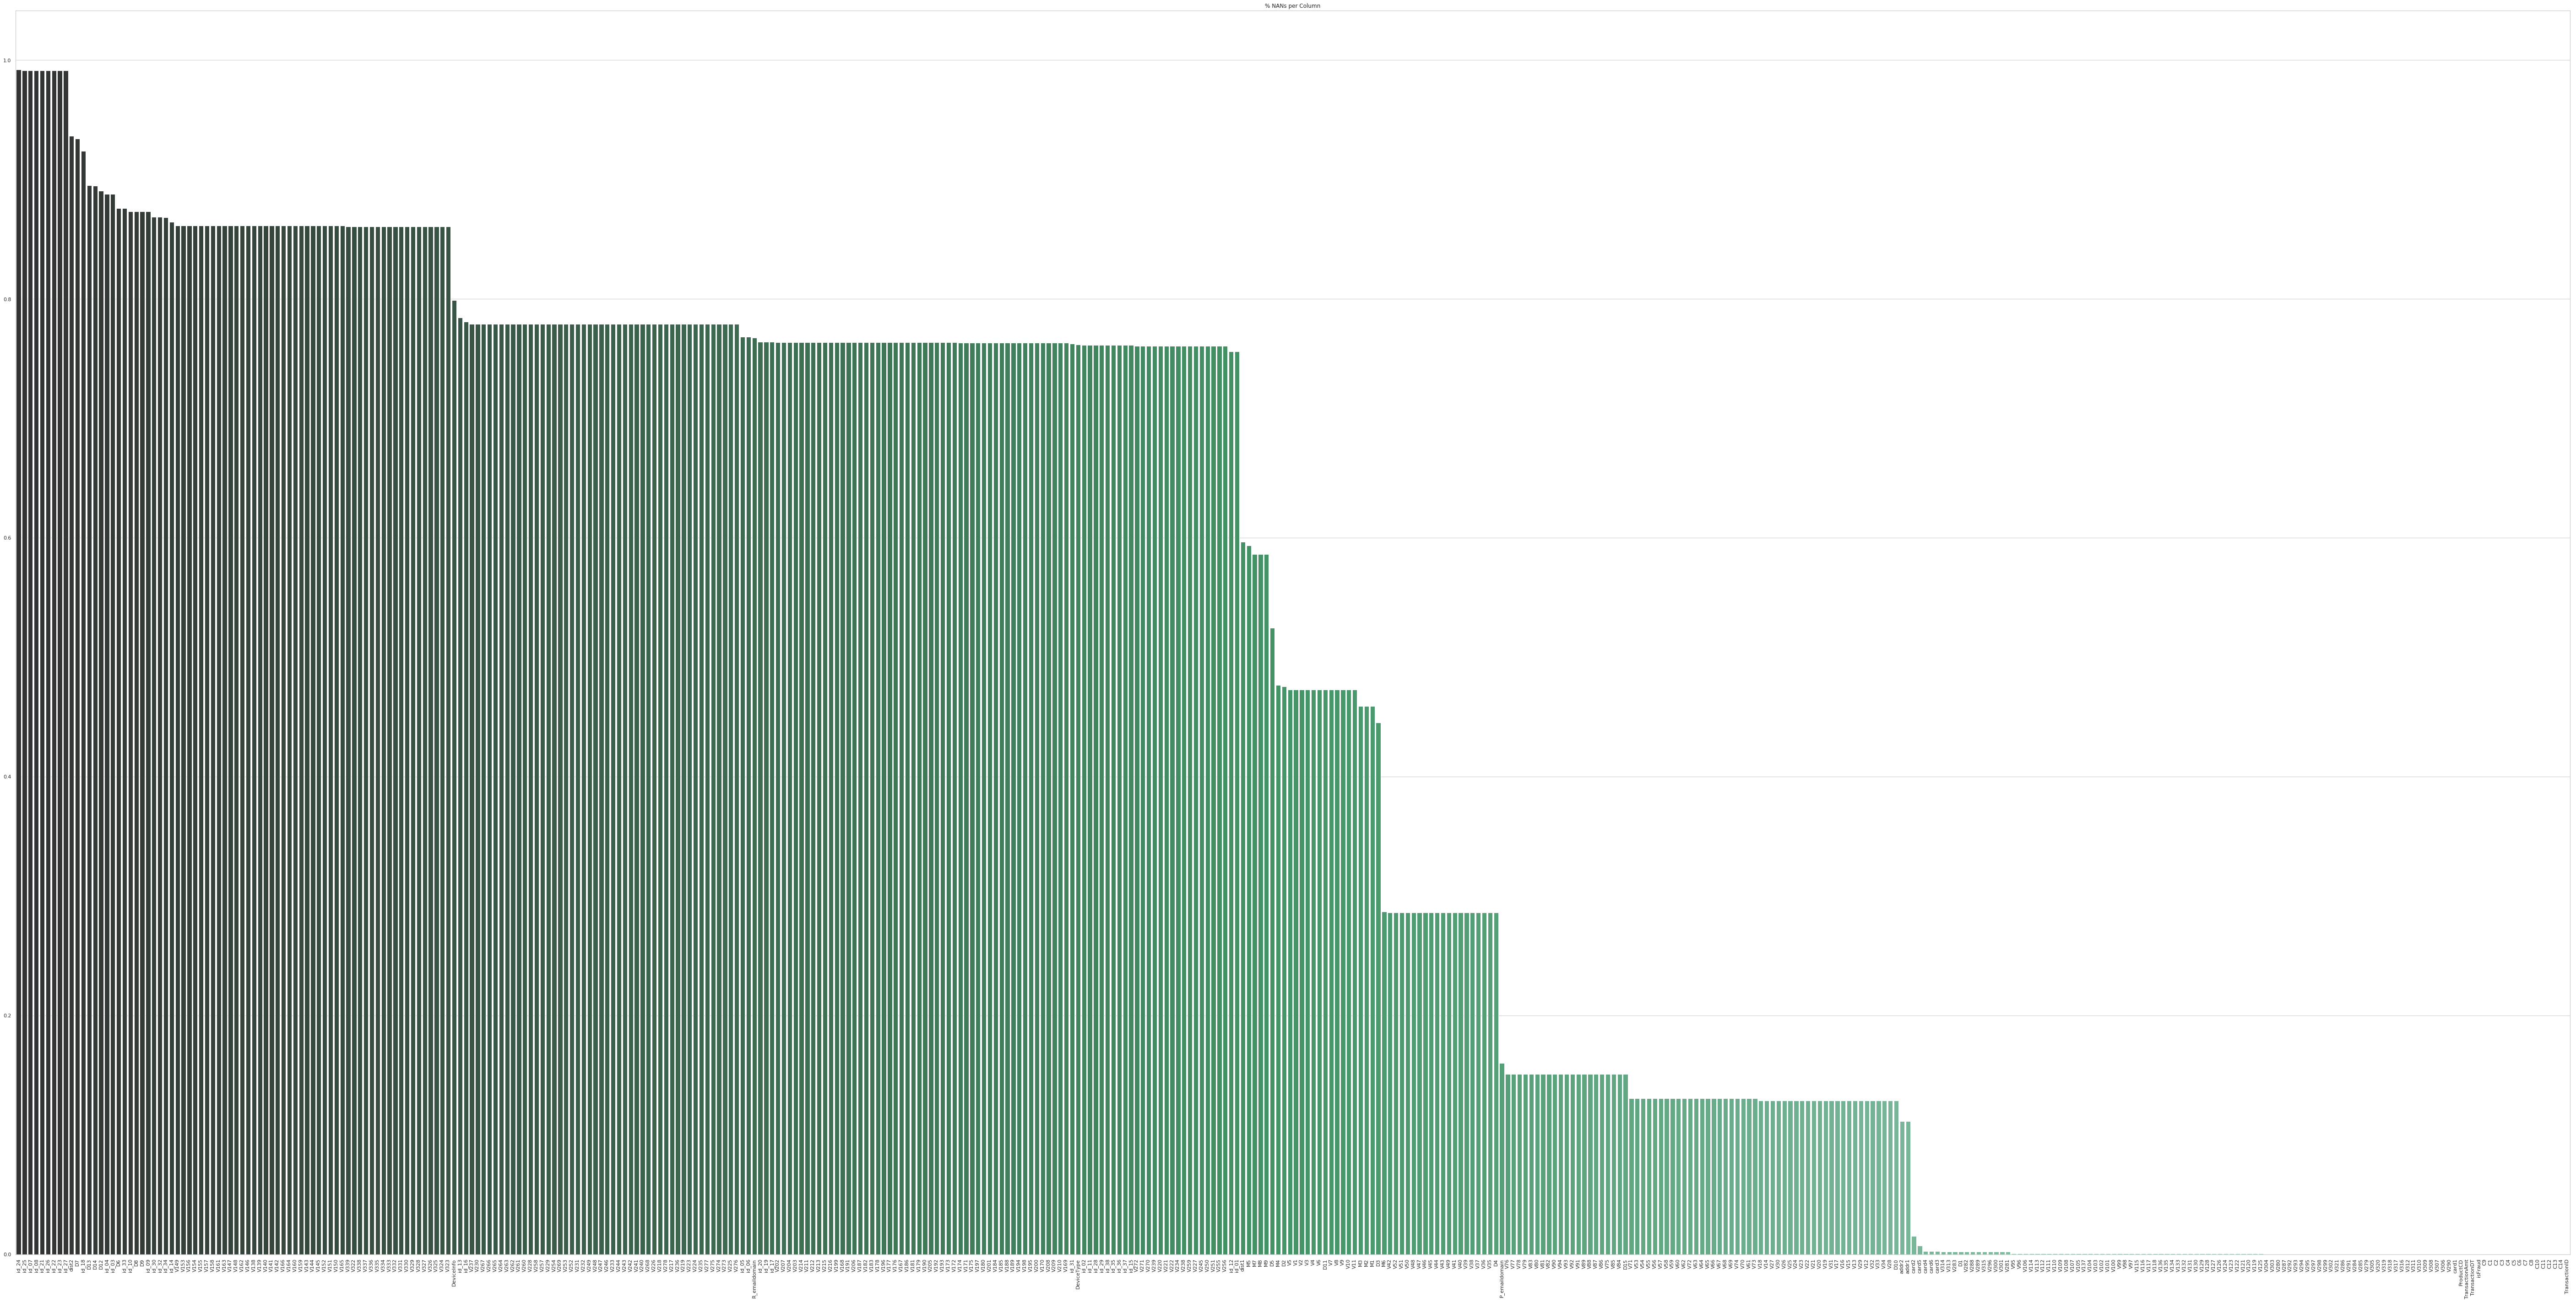

In [24]:
#Visualizing NANs % per Column
X = df_train.isnull().sum().sort_values(ascending = False).index
Y = df_train.isnull().sum().sort_values(ascending = False)/len(df_train)
color = "BuGn_d"
visualize(X, Y, color)

In [0]:
df_cols_nans_count = df_train.isnull().sum().sort_values(ascending = False)
df_cols_nans_per = df_cols_nans_count/len(df_train)
df_cols_nans = pd.DataFrame({"nans_count" : df_cols_nans_count, "nans_%" : df_cols_nans_per})

In [26]:
cols_drop_range = np.array([0.05, 0.10, 0.15, 0.20, 0.35, 0.45, 0.50, 0.70])
for col in range(len(cols_drop_range)):
  remaining_cols = df_cols_nans[df_cols_nans['nans_%'] <= cols_drop_range[col]]
  print('For using ', cols_drop_range[col], 'as a limiter we are left with ',remaining_cols.shape[0]/df_train.shape[1],'% of columns.')

For using  0.05 as a limiter we are left with  0.25806451612903225 % of columns.
For using  0.1 as a limiter we are left with  0.25806451612903225 % of columns.
For using  0.15 as a limiter we are left with  0.3686635944700461 % of columns.
For using  0.2 as a limiter we are left with  0.41935483870967744 % of columns.
For using  0.35 as a limiter we are left with  0.46543778801843316 % of columns.
For using  0.45 as a limiter we are left with  0.46774193548387094 % of columns.
For using  0.5 as a limiter we are left with  0.5069124423963134 % of columns.
For using  0.7 as a limiter we are left with  0.5207373271889401 % of columns.


In [28]:
limiter = 0.2
discarded_cols = df_cols_nans[df_cols_nans['nans_%'] > limiter].index
df_train = df_train.drop(columns = discarded_cols)
df_train.shape

(590540, 182)

In [0]:
def encoding_categoricals(df):
  categorical_features = df.select_dtypes(include=[object])
  encoded_categorical_features = pd.get_dummies(categorical_features)
  df = df.drop(columns = categorical_features)
  df = pd.concat([df, encoded_categorical_features], axis = 1)
  return df

In [0]:
def fill_nans(df):
  df = df.fillna(df.mode())
  df = df.dropna()
  return df

In [31]:
df_train = encoding_categoricals(df_train)
df_train = fill_nans(df_train)
df_train.shape

(423711, 250)

Splitting training data into features and target variable

In [0]:
X_train = df_train[df_train.columns.difference(['isFraud'])]
y_train = df_train['isFraud']

In [33]:
print('X train : ', X_train.shape, ' Y train : ', y_train.shape)

X train :  (423711, 249)  Y train :  (423711,)


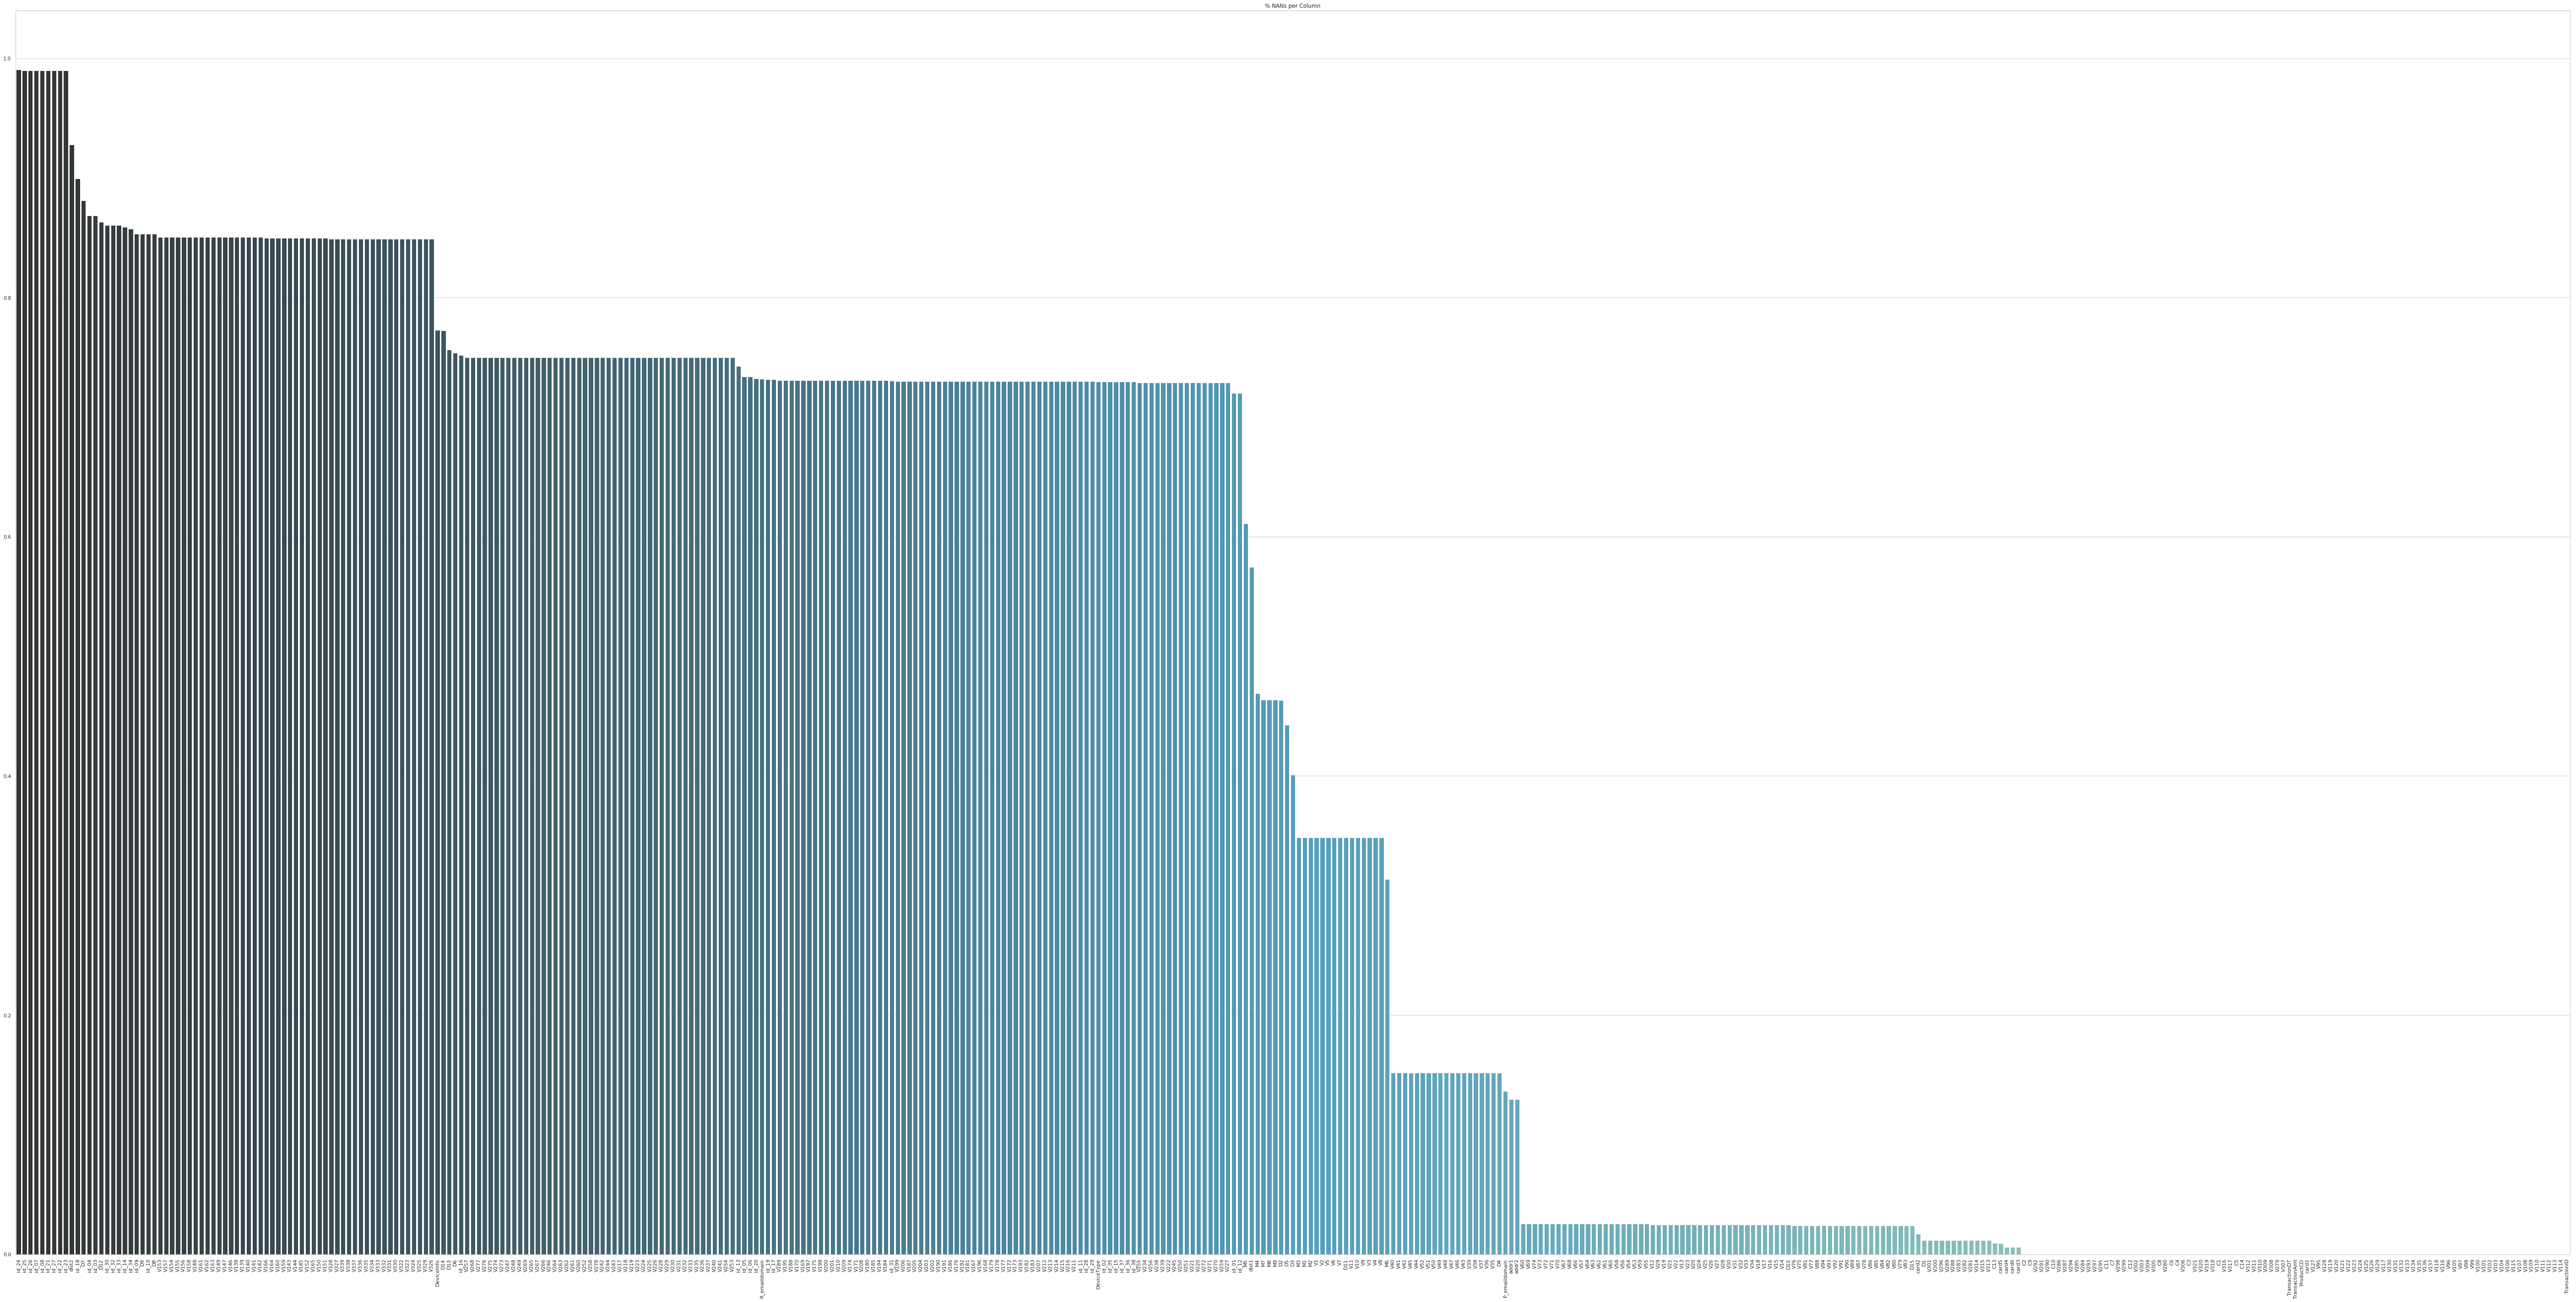

In [34]:
#Visualizing NANs % per Column
X = df_test.isnull().sum().sort_values(ascending = False).index
Y = df_test.isnull().sum().sort_values(ascending = False)/len(df_test)
color = "GnBu_d"
visualize(X, Y, color)

In [35]:
#discarding the same columns as in train data
df_test = df_test.drop(columns = discarded_cols)
df_test.shape

(506691, 181)

In [36]:
#Encoding categorical features and filling remaining nans with mode
df_test = encoding_categoricals(df_test)
df_test = fill_nans(df_test)
df_test.shape

(412087, 249)

In [0]:
X_test = df_test[df_test.columns.difference(['isFraud'])]

Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression

In [39]:
regressor = LogisticRegression(solver = 'lbfgs')
regressor.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
regressor.score(X_train, y_train)

0.9795922220570152

In [0]:
y_train_pred = regressor.predict(X_train)

In [42]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(regressor, X_train, y_train[:np.shape(X_train)[0]], cv=3, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.979, total=  19.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.2s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


[CV] .................................... , score=0.980, total=  19.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   38.9s remaining:    0.0s


[CV] .................................... , score=0.979, total=   8.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   47.2s finished


0.9792759687617267